In [5]:
import pandas as pd
df = pd.read_csv('data.csv',encoding='unicode_escape')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank']==1]

In [11]:
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days
df_rec.head()

<ipython-input-11-84fe478679fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,rank,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1.0,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1.0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0,0


In [12]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

In [14]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')
rec_freq.head()

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency
0,12346.0,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,United Kingdom,2011-01-18 10:01:00,1.0,48
1,12347.0,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6
2,12347.0,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6
3,12347.0,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6
4,12347.0,31,537626,22492,MINI PAINT SET VINTAGE,36,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6


In [17]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']
rfm = m.merge(rec_freq,on='CustomerID')

In [19]:
finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

To identify outlier, creating a boxplot visual

recency: 


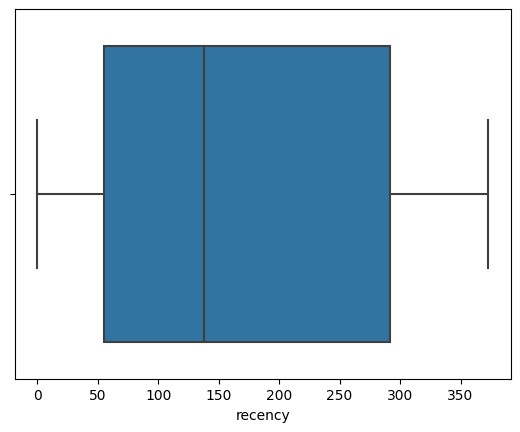

frequency: 


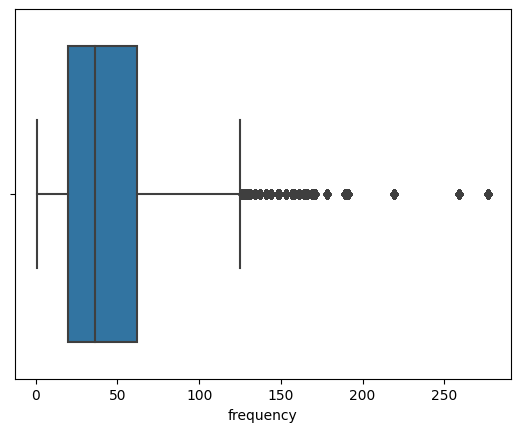

monetary_value: 


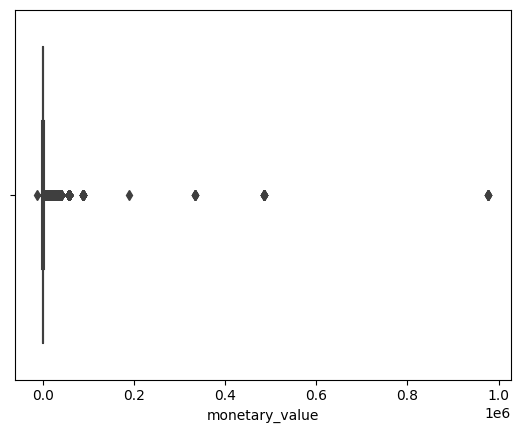

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

Removing Outliers

In [22]:
from scipy import stats
import numpy as np
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]
new_df.head()

,recency,frequency,monetary_value
1,6,31,1246.73
2,6,31,1246.73
3,6,31,1246.73
4,6,31,1246.73
5,6,31,1246.73


Standradization

In [25]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,recency,frequency,monetary_value
0,-1.196723,0.379971,0.185080
1,-1.120665,-0.259085,1.965919
2,1.752654,2.297138,0.401256
3,-0.715020,-0.259085,-0.217826
4,-0.596706,-0.350378,0.011294


Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

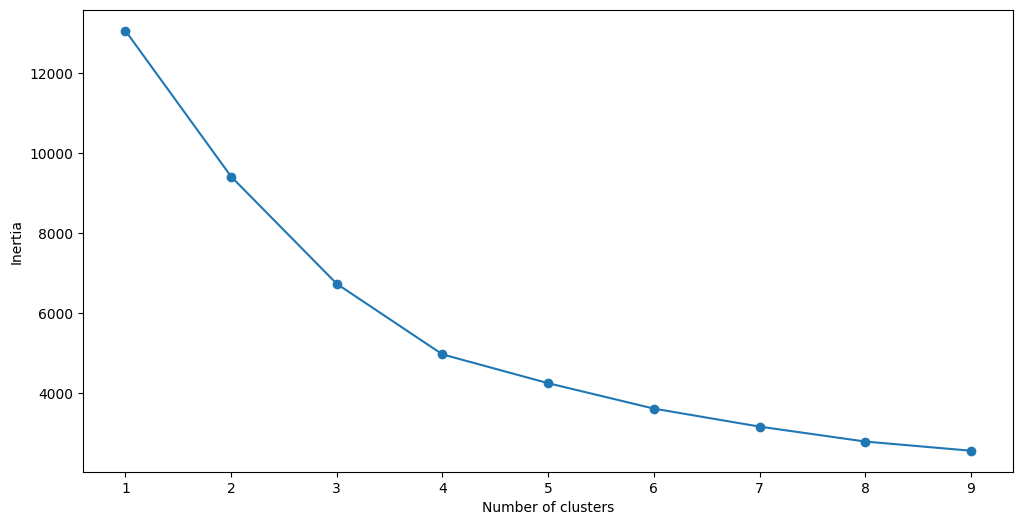

In [26]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [27]:
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [29]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.4360722849503388


Segmentation

In [31]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred
frame.head()

,recency,frequency,monetary_value,cluster
1,6,31,1246.73,1
32,15,17,4311.90,1
49,355,73,1618.81,2
122,63,17,553.25,1
139,77,15,947.61,1


Visualization

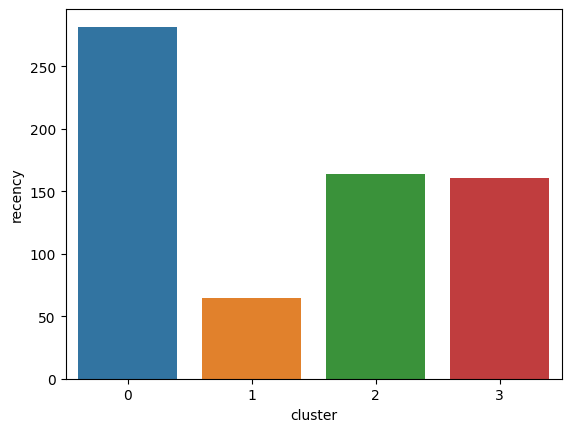

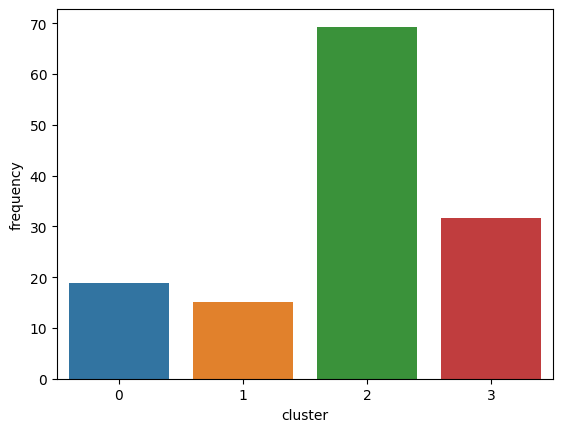

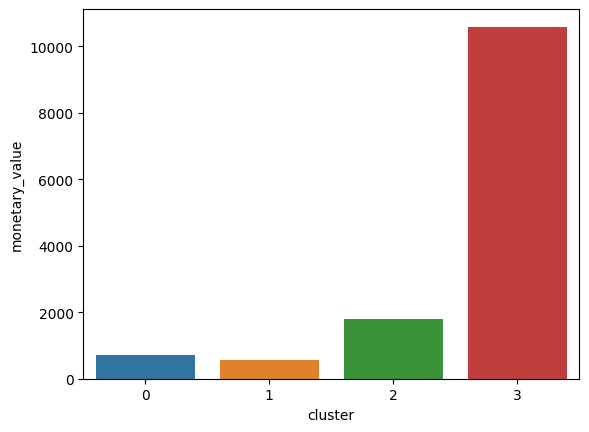

In [32]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()